# Project 3: Regression

[Philip Vishnevsky](https://github.com/zenatron)  
2025-03-30

## 1. Introduction

### 1.1 Objectives

For Project 3, we will be creating a regression model in order to predict song popularity based on musical parameters, such as tempo, energy, loudness, time signature, and other features. We will use the [Spotify 1 Million Tracks Dataset from Kaggle](https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks), which contains a large set of over 1,000,000 tracks from Spotify, along with 19 features. The dataset appears to be mostly clean and ready for modeling; however, some preprocessing still may be necessary.

### 1.2 Questions to Answer

From this Project, we aim to answer the following questions:
1. Can we accurately predict the popularity of a song using solely its musical parameters?
2. Can we accurately predict the popularity of a song prior to its public release?
3. Which features are most important to predicting song popularity, irregardless of artist?

### 1.3 Data Introduction

The chosen dataset describes 1 million songs from Spotify, released between 2000 and 2023. It was chosen for its large sample size and vastness of musical parameters, aiding our overall goal.

The dataset initially contained the following features:

- **`Popularity`**: Track popularity (0 to 100)  
- **`Year`**: Year released (2000 to 2023)  
- **`Danceability`**: Track suitability for dancing (0.0 to 1.0)  
- **`Energy`**: The perceptual measure of intensity and activity (0.0 to 1.0)  
- **`Key`**: The key the track is in (-1 to -11)  
- **`Loudness`**: Overall loudness of track in decibels (-60 to 0 dB)  
- **`Mode`**: Modality of the track (Major ‘1’/ Minor ‘0’)  
- **`Speechiness`**: Presence of spoken words in the track  
- **`Acousticness`**: Confidence measure from 0 to 1 of whether the track is acoustic  
- **`Instrumentalness`**: Whether tracks contain vocals (0.0 to 1.0)  
- **`Liveness`**: Presence of audience in the recording (0.0 – 1.0)  
- **`Valence`**: Musical positiveness (0.0 to 1.0)  
- **`Tempo`**: Tempo of the track in beats per minute (BPM)  
- **`Time_signature`**: Estimated time signature (3 to 7)  
- **`Duration_ms`**: Duration of track in milliseconds

In our preprocessing steps further below, we will refine and remove any irrelevant features.

### 1.4 What is Linear Regression?

Linear regression is a statistical technique used to model the relationship between a dependent variable Y and one or more independent variables X.

The basic formula for simple linear regression (one variable X) is:
$$
Y = \beta_0 + \beta_1 X + \epsilon 
$$

For multiple linear regression, the general formula is:
$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_n X_n + \epsilon 
$$

Where:
- $Y = \text{dependent variable, that we are predicting}$
- $\beta_0 = \text{intercept term, when X = 0}$
- $X_1, X_2, \ldots, X_n = \text{features (independent variables)}$
- $\beta_1, \beta_2, \ldots, \beta_n = \text{coefficients (weights for each feature)}$
- $\epsilon = \text{error term, accounting for variability not explained by model}$

The normal equation for computing the beta coefficients is:
$$
\beta = (X^TX)^{-1}X^TY
$$

---

## 2. Experiment One: Linear Regression

For the first experiment, we will implement, fit, and evaluate a multiple linear regression model on the dataset.

### 2.0 Library Imports

In [15]:
#pip install --upgrade xgboost cupy-cuda12x shap

In [16]:
# Import data libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cupy as cp
import shap

# Import Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Import Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance

# Import Metrics
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error

# Suppress Warnings
import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning])
#warnings.filterwarnings('ignore', category=RuntimeWarning)

### 2.1 Data Preview & Understanding

In [18]:
# Load the dataset
path = "./data/spotify_data.csv"
df = pd.read_csv(path, low_memory=False)

In [19]:
# We will define a function to display some detailed information about our dataframe

def show_info(dataframe):
    # Display first few rows
    print("\nFirst Few Rows\n")
    display(dataframe.head())
    
    # Basic stats
    print("\nBasic Numeric Stats\n")
    display(dataframe.describe())
    
    print("\nShape & Cols\n")
    print(dataframe.shape)
    print(dataframe.columns)
    
    # Show column info
    print("\nDetailed Column Info\n")
    dataframe.info(verbose=True, show_counts=True)

In [20]:
show_info(df)


First Few Rows



,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4



Basic Numeric Stats



,Unnamed: 0,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06
mean,6.590613e+05,1.838312e+01,2.011955e+03,5.374382e-01,6.396699e-01,5.287778e+00,-8.981353e+00,6.346533e-01,9.281477e-02,3.215370e-01,2.523489e-01,2.230189e-01,4.555636e-01,1.213771e+02,2.495618e+05,3.885879e+00
std,4.285492e+05,1.588554e+01,6.803901e+00,1.844780e-01,2.705009e-01,3.555197e+00,5.682215e+00,4.815275e-01,1.268409e-01,3.549872e-01,3.650731e-01,2.010707e-01,2.685190e-01,2.977975e+01,1.494262e+05,4.676967e-01
min,0.000000e+00,0.000000e+00,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-5.810000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.073000e+03,0.000000e+00
25%,2.899408e+05,5.000000e+00,2.006000e+03,4.130000e-01,4.540000e-01,2.000000e+00,-1.082900e+01,0.000000e+00,3.710000e-02,6.400000e-03,1.050000e-06,9.790000e-02,2.260000e-01,9.879700e+01,1.810910e+05,4.000000e+00
50%,5.798815e+05,1.500000e+01,2.012000e+03,5.500000e-01,6.940000e-01,5.000000e+00,-7.450000e+00,1.000000e+00,5.070000e-02,1.470000e-01,1.760000e-03,1.340000e-01,4.380000e-01,1.219310e+02,2.257440e+05,4.000000e+00
75%,1.031689e+06,2.900000e+01,2.018000e+03,6.770000e-01,8.730000e-01,8.000000e+00,-5.276000e+00,1.000000e+00,8.900000e-02,6.400000e-01,6.140000e-01,2.920000e-01,6.740000e-01,1.399030e+02,2.869135e+05,4.000000e+00
max,1.473395e+06,1.000000e+02,2.023000e+03,9.930000e-01,1.000000e+00,1.100000e+01,6.172000e+00,1.000000e+00,9.710000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.499930e+02,6.000495e+06,5.000000e+00



Shape & Cols

(1159764, 20)
Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

Detailed Column Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159764 non-null  int64  
 1   artist_name       1159749 non-null  object 
 2   track_name        1159763 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null

### Visualize Correlation Matrix

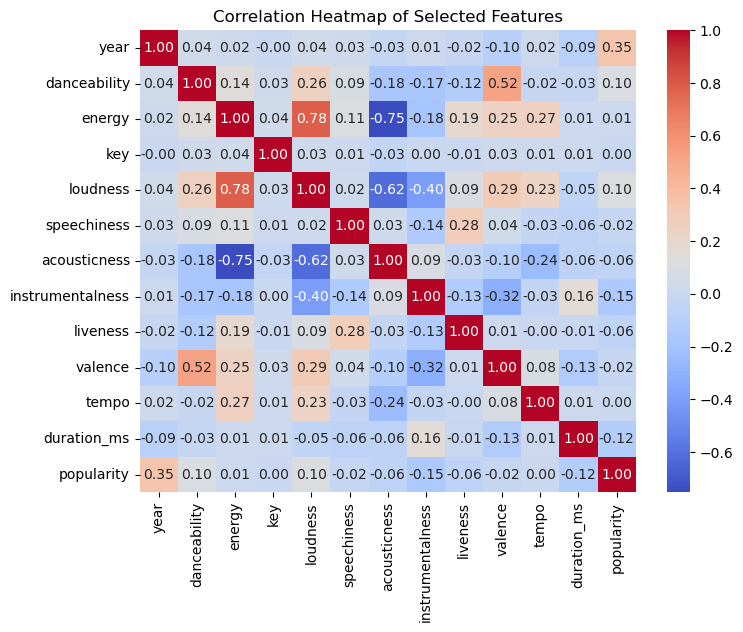

In [22]:
# Select a subset of continuous variables
numeric_cols = ['year', 'danceability', 'energy', 'key',
                'loudness', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 
                'tempo', 'duration_ms', 'popularity']

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

We see linear corrleation betweeen certain variables, such as a strong negative correlation between acousticness and energy, acousticness and loudness, and instrumentalness and loudness. We also see positive correlation between loudness and energy, and valence and danceability. Of course, it is not surprising that these variables are related, yet it will be interesting to see what impact they will have on modeling and prediction.

### 2.2 Data Preprocessing

We will start by dropping unnecessary columns. Columns like `Unnamed: 0` and `track_id` bring no value to our modeling. Columns like `artist_name` and `track_name` can lead to data leakage, as the model may learn to predict popularity based on a popular artist's name (i.e. Taylor Swift or Ariana Grande), rather than purely from musical parameters.

In [26]:
cols_to_drop = ['Unnamed: 0', 'artist_name', 'track_name', 'track_id']
df_dropped = df.drop(cols_to_drop, axis=1)

We will also encode the `year` column as `2023 - year`, to get the number of years since song release.

In [28]:
df_dropped['year'] = 2023 - df_dropped['year']

Now, we will create additive features.

In [30]:
df_dropped['dance_energy'] = df_dropped['danceability'] * df_dropped['energy']
df_dropped['valence_tempo'] = df_dropped['valence'] * df_dropped['tempo']

Since we cannot use the artist's name as a column, we will create a column to tally the number of songs released by that artist. Lesser popular songs are likely to be created by artists with fewer releases.

In [32]:
# Count songs per artist
artist_song_counts = df['artist_name'].value_counts()

# Map the counts back to the dataframe
df_dropped['artist_song_count'] = df['artist_name'].map(artist_song_counts)
df_dropped['artist_song_count'] = df_dropped['artist_song_count'].fillna(1)

Now that we have dropped irrelevant columns, we can proceed with checking for any missing values.

In [34]:
# Display only cols with null vals, and print num rows w missing vals
missing_values = df_dropped.isnull().sum()
display(missing_values[missing_values > 0])
missing_value_count = missing_values[missing_values > 0].count()
print(f"Number of columns with missing values: {missing_value_count}")

Series([], dtype: int64)

Number of columns with missing values: 0


We can see there are no missing values.

However, we see the `genre` feature is a string. It will need to be encoded numerically for modeling.

We will one-hot encode using `get_dummies` with `drop_first=True` to avoid multicollinearity.

In [36]:
df_encoded = pd.get_dummies(df_dropped, columns=['genre'], drop_first=True)

In [37]:
show_info(df_encoded)


First Few Rows



,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,genre_ska,genre_sleep,genre_songwriter,genre_soul,genre_spanish,genre_swedish,genre_tango,genre_techno,genre_trance,genre_trip-hop
0,68,11,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,50,11,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,...,False,False,False,False,False,False,False,False,False,False
2,57,11,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,...,False,False,False,False,False,False,False,False,False,False
3,58,11,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,...,False,False,False,False,False,False,False,False,False,False
4,54,11,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,...,False,False,False,False,False,False,False,False,False,False



Basic Numeric Stats



,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,dance_energy,valence_tempo,artist_song_count
count,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06
mean,1.838312e+01,1.104500e+01,5.374382e-01,6.396699e-01,5.287778e+00,-8.981353e+00,6.346533e-01,9.281477e-02,3.215370e-01,2.523489e-01,2.230189e-01,4.555636e-01,1.213771e+02,2.495618e+05,3.885879e+00,3.507327e-01,5.595898e+01,1.178108e+02
std,1.588554e+01,6.803901e+00,1.844780e-01,2.705009e-01,3.555197e+00,5.682215e+00,4.815275e-01,1.268409e-01,3.549872e-01,3.650731e-01,2.010707e-01,2.685190e-01,2.977975e+01,1.494262e+05,4.676967e-01,1.853440e-01,3.667326e+01,3.016462e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.810000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.073000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,5.000000e+00,5.000000e+00,4.130000e-01,4.540000e-01,2.000000e+00,-1.082900e+01,0.000000e+00,3.710000e-02,6.400000e-03,1.050000e-06,9.790000e-02,2.260000e-01,9.879700e+01,1.810910e+05,4.000000e+00,2.095020e-01,2.592107e+01,2.200000e+01
50%,1.500000e+01,1.100000e+01,5.500000e-01,6.940000e-01,5.000000e+00,-7.450000e+00,1.000000e+00,5.070000e-02,1.470000e-01,1.760000e-03,1.340000e-01,4.380000e-01,1.219310e+02,2.257440e+05,4.000000e+00,3.618060e-01,5.132775e+01,5.400000e+01
75%,2.900000e+01,1.700000e+01,6.770000e-01,8.730000e-01,8.000000e+00,-5.276000e+00,1.000000e+00,8.900000e-02,6.400000e-01,6.140000e-01,2.920000e-01,6.740000e-01,1.399030e+02,2.869135e+05,4.000000e+00,4.890000e-01,8.074121e+01,1.140000e+02
max,1.000000e+02,2.300000e+01,9.930000e-01,1.000000e+00,1.100000e+01,6.172000e+00,1.000000e+00,9.710000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.499930e+02,6.000495e+06,5.000000e+00,9.516000e-01,2.273503e+02,4.058000e+03



Shape & Cols

(1159764, 99)
Index(['popularity', 'year', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'dance_energy',
       'valence_tempo', 'artist_song_count', 'genre_afrobeat',
       'genre_alt-rock', 'genre_ambient', 'genre_black-metal', 'genre_blues',
       'genre_breakbeat', 'genre_cantopop', 'genre_chicago-house',
       'genre_chill', 'genre_classical', 'genre_club', 'genre_comedy',
       'genre_country', 'genre_dance', 'genre_dancehall', 'genre_death-metal',
       'genre_deep-house', 'genre_detroit-techno', 'genre_disco',
       'genre_drum-and-bass', 'genre_dub', 'genre_dubstep', 'genre_edm',
       'genre_electro', 'genre_electronic', 'genre_emo', 'genre_folk',
       'genre_forro', 'genre_french', 'genre_funk', 'genre_garage',
       'genre_german', 'genre_gospel', 'genre_goth', 'genre_grindcore',
       'genre_groove', 'genre_guita

Now, we have one-hot encoded the `genre` column. All of our columns are now numeric.

### 2.3 Modeling

First, we will split the data into training and testing datasets.

In [134]:
# Separate features and target (popularity is our target variable)
X = df_encoded.drop('popularity', axis=1)
y = df_encoded['popularity']

In [42]:
# Split data into training and test sets (using stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We will visualize the distribution of the target variable `y`

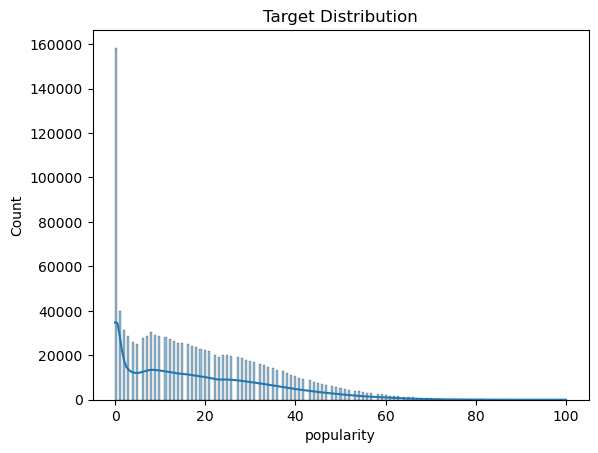

In [44]:
sns.histplot(y, kde=True)
plt.title("Target Distribution")
plt.show()

Create the pipeline

In [46]:
lr = Pipeline(steps=[
    ("regressor", LinearRegression(n_jobs=-1))
])

In [47]:
lr.fit(X_train, y_train)

Pipeline(steps=[('regressor', LinearRegression(n_jobs=-1))])

### 2.4 Evaluation

Next, we will evaluate the Linear Regression model using the R^2 and RMSE scores

In [50]:
y_pred = lr.predict(X_test)

In [51]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.3f}, RMSE: {rmse:.2f}")

R²: 0.547, RMSE: 10.69


We see that it performs quite poorly, with an average error of over 10 points.

___

## 3. Experiment Two: Histogram-based Gradient Boosting Regression Tree

For the second experiement, we will implement histogram-based gradient boosting regression tree.

Histogram-Based Gradient Boosting Decision Trees (HGBDT or HGBR for regression) work by building an ensemble of decision trees in a stage-wise fashion, where each new tree is trained to correct the errors made by the combined previous trees. What sets HGB apart is its use of histogram-based binning to speed up training and reduce memory usage. Instead of evaluating every unique value in the dataset for splits, HGB first discretizes continuous features into a fixed number of bins (histograms), and then finds the optimal split points from those bins. This significantly accelerates the split-finding process without a major loss in accuracy. Like other gradient boosting methods, HGB minimizes a loss function (in our case, Mean Squared Error) using gradient descent, and it naturally handles non-linear relationships and feature interactions.

In [56]:
pipeline = Pipeline(steps=[
    ('regressor', HistGradientBoostingRegressor(
        l2_regularization = 10.0,
        learning_rate = 0.2,
        max_depth = 10,
        max_iter = 1000,
        min_samples_leaf = 100
    ))
])

In [57]:
# Define the parameter grid. For Ridge, we tune the regularization strength 'alpha'.
# param_grid = {
#     'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'regressor__max_iter': [100, 300, 500, 1000],
#     'regressor__max_depth': [None, 5, 10],
#     'regressor__min_samples_leaf': [20, 50, 100],
#     'regressor__l2_regularization': [0.0, 1.0, 10.0],
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("Best parameters found:", grid_search.best_params_)
# print("Best cross-validation R^2:", grid_search.best_score_)

# # You can now use the best model:
# best_model = grid_search.best_estimator_

# score = best_model.score(X_test, y_test)
# print(f"R^2 on test set: {score:.3f}")

We have used the above code to perform a grid search to find the best parameters for the model. The results are detailed below:

Best parameters found: {'regressor__l2_regularization': 10.0, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 10, 'regressor__max_iter': 1000, 'regressor__min_samples_leaf': 100}
Best cross-validation R^2 on test set: 0.695

Now, we will fit and evaluate the model.

In [60]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('regressor',
                 HistGradientBoostingRegressor(l2_regularization=10.0,
                                               learning_rate=0.2, max_depth=10,
                                               max_iter=1000,
                                               min_samples_leaf=100))])

In [61]:
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.3f}, RMSE: {rmse:.2f}")

R²: 0.695, RMSE: 8.77


We see that the Histogram Gradient Boosting Regressor performs moderately better than the Linear Regression model, reaching an R^2 score of 0.695, indicating an accuracy improvement of 0.148, and over a 2 point improvement in mean error.

---

## 4. Experiment Three: XGBoost

For the third experiment, we will implement XGBoost, a popular algorithm that can benefit from parallel GPU compute.

XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of gradient boosting machines, designed for speed, performance, and flexibility. Like other boosting methods, XGBoost builds an ensemble of decision trees in a sequential manner, where each tree attempts to correct the residual errors of the previous ones. What sets XGBoost apart is its use of advanced regularization (via `reg_alpha` and `reg_lambda`) to reduce overfitting, its support for parallel computation, and its ability to efficiently handle sparse data. It also supports GPU acceleration, which dramatically speeds up training on large datasets. To fine-tune the model’s performance, we implemented a randomized grid search to optimize key hyperparameters such as the number of trees (`n_estimators`), learning rate, maximum tree depth, and regularization terms. This approach allowed us to systematically explore a wide range of model configurations and identify the combination that yielded the highest R² score on our validation sets.

In [66]:
# # Define a hyperparameter search space
# param_dist = {
#     'n_estimators': [100, 300, 500, 700, 1000, 5000],
#     'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 6, 8, 10, 12],
#     'min_child_weight': [1, 3, 5, 10, 20],
#     'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.3, 0.5, 1],
#     'reg_alpha': [0, 0.01, 0.1, 1, 10],
#     'reg_lambda': [0.1, 1, 5, 10, 50],
# }

# # Set up the randomized search
# random_search = RandomizedSearchCV(
#     estimator=XGBRegressor(device='cuda', objective='reg:squarederror', random_state=42),
#     param_distributions=param_dist,
#     scoring='r2',
#     n_iter=100,               # Number of random combos to try
#     cv=3,
#     verbose=2,
#     random_state=42,
#     n_jobs=15
# )

# # Fit the model
# random_search.fit(X_train, y_train)

# # Output results
# print("Best R² Score: {:.4f}".format(random_search.best_score_))
# print("Best Parameters:", random_search.best_params_)

The optimal hyperparameters have been included in the model constructor below. Additionally, we split off a validation set for use with early stopping, ensuring that our model does not waste time with negligible improvements. We make the model use GPU acceleration by setting the `device="cuda"` in the XGB constructor (for NVIDIA GPUs).

In [146]:
# Split a validation set from the training data
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [148]:
# Define the model
xgb = XGBRegressor(
    tree_method="hist",
    device="cuda",
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=15,
    min_child_weight=5,
    subsample=1,
    reg_lambda=0.1,
    reg_alpha=0.01,
    colsample_bytree=0.5,
    early_stopping_rounds=20,
    eval_metric='rmse',
    random_state=42,
)

In [142]:
# Fit with early stopping
xgb.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device='cuda', early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

In [143]:
# Predict on final test set
y_pred = xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.3f}, RMSE: {rmse:.2f}")

R²: 0.630, RMSE: 8.69


We see a significantly improved R^2 score of 0.722 using the XGB model as compared to the Linear Regression model. The average error has also dropped to 8.38. Unfortunately, our testing did not showy any significant improvements from this value, indicating that there must be other factors at play which determine song popularity.

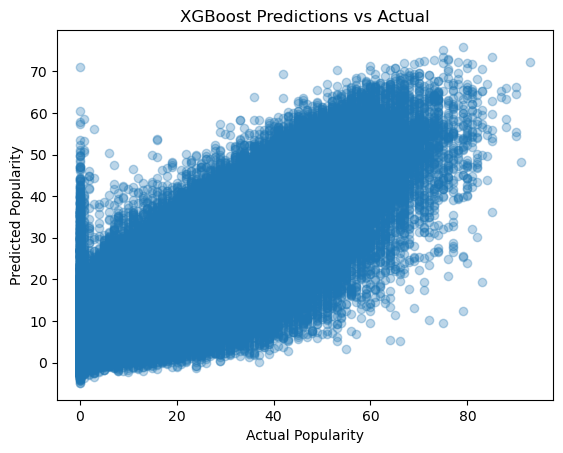

In [73]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("XGBoost Predictions vs Actual")
plt.show()

<Figure size 1200x600 with 0 Axes>

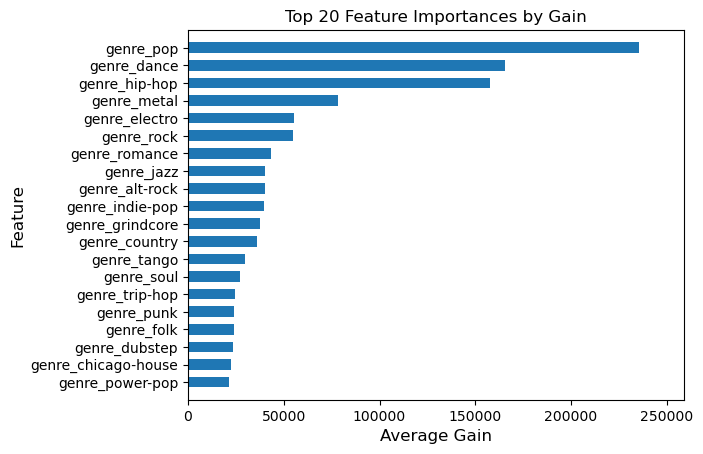

<Figure size 1200x600 with 0 Axes>

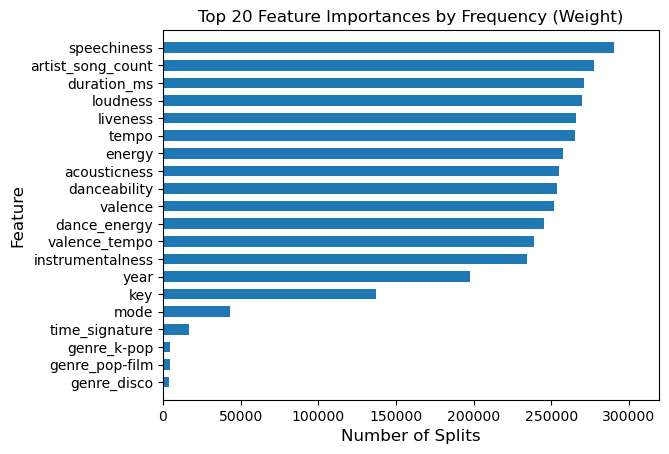

In [74]:
plt.figure(figsize=(12, 6))
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                height=0.6, grid=False, show_values=False)
plt.title("Top 20 Feature Importances by Gain")
plt.xlabel("Average Gain", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()

plt.figure(figsize=(12, 6))
plot_importance(xgb, max_num_features=20, importance_type='weight', 
                height=0.6, grid=False, show_values=False)
plt.title("Top 20 Feature Importances by Frequency (Weight)")
plt.xlabel("Number of Splits", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()

---

## 5. Conclusion

Over the course of this project, we explored the challenge of predicting a track's popularity using a combination of regression models and a wide range of audio and metadata features. Our dataset included key musical attributes like danceability, energy, acousticness, and speechiness, along with genre flags and the release year. The target variable, popularity, was highly right-skewed, with a median of 15 and a large concentration of low values. This made modeling difficult, especially for linear models. We began with a baseline Linear Regression model, which achieved an R² score of **0.547**, capturing some of the trend but falling short in modeling non-linear patterns or accounting for feature interactions.

To address these limitations, we implemented two tree-based models: Histogram-Based Gradient Boosting Regressor (HGBR) and XGBoost. The HGBR model significantly improved performance, reaching an R² of **0.695**. It was more effective at capturing non-linear relationships in the data and began highlighting which features mattered most. XGBoost, however, outperformed both previous models. With early stopping enabled and model tuning, it achieved an R² of **0.722**, making it the best-performing model in our pipeline. This performance boost came from both hyperparameter tuning and targeted feature engineering — including transforming `year` into a “track age” feature and introducing a new `artist_song_count` feature as a proxy for an artist’s reach.

To better understand what the XGBoost model was learning, we visualized feature importance in two ways: by **gain** (how much each feature improved splits) and by **weight** (how often a feature was used in splits). These plots revealed that the most impactful features were `speechiness`, `artist_song_count`, and key genre flags such as `genre_dance`, `genre_pop`, and `genre_hip-hop`. Features like danceability, instrumentalness, and acousticness played a secondary role. The gain-based plot helped us understand which features contributed the most to the model's accuracy, while the weight-based plot gave us insight into which features were used most frequently in decision-making, even if their individual impact was smaller.

In conclusion, this project demonstrated how model performance can be dramatically improved not just through algorithm selection, but through deep understanding of the data. From Linear Regression to tree-based models, each step forward was enabled by better features, better structure, and more thoughtful interpretation. While there’s room for improvement (e.g., incorporating social data, playlist features, or user interactions), our final XGBoost model provides a robust, interpretable solution for predicting track popularity based solely on intrinsic song attributes and artist-level context.

## 6. Impact

By building a model that predicts song popularity from its musical parameters, we are able to shed some light onto the specific elements -- genres, tempos, and styles of music -- may lead to a song's success. The findings from this project could help producers, record labels, and indie artists by estimating the popularity of their songs, even before they are released.

Additionally, a popularity score could prove to be especially valuable for marketing and promotional strategies by providing a quantifiable estimate of the song's popularity. Ultimately, this may help level the playing field for all artists in the industry, and allow indie producers to get their work out to ears across the world more easily.

However, a potential negative impact of this study is that it may encourage producers to conform to a data-driven formula for success. This could potentially limit artistic creativity and diversity in music, in favor of getting the most "clicks" or "plays."

## 7. References

Dataset Used: https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks